1. Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten,GlobalMaxPooling1D,Embedding,LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

2.Read , Preprocessing and cleaning Dataset

In [2]:
#Read dataset 
movie_reviews=pd.read_csv("IMDB Dataset.csv")
#show the first 5 Rows
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
#show the Last 5 Rows
movie_reviews.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [4]:
#Check the missing values in the data 
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
#Show the rows and columns in the data
movie_reviews.shape

(50000, 2)

In [6]:
#check the data
movie_reviews['review'][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

<Axes: xlabel='sentiment', ylabel='count'>

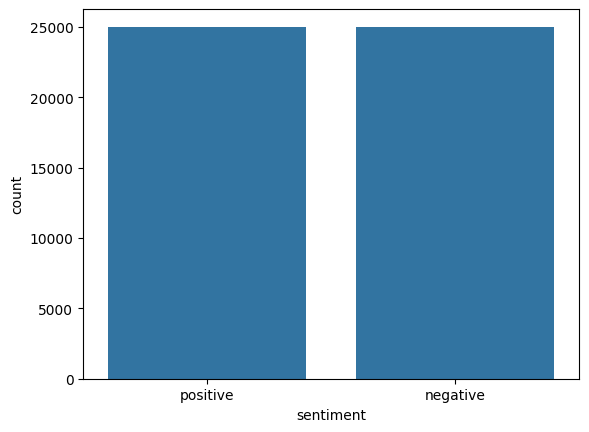

In [7]:
#show the count of the sentiment of movies
sns.countplot(x='sentiment',data=movie_reviews)

In [8]:
#Heml format removing
TAG_RE=re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('',text)

In [9]:
def preprocess_text(sen):
    #Removing html tags
    sentence=remove_tags(sen)

    #Remove Punctions and numbers 
    sentence=re.sub('[^a-zA-Z]',' ',sentence)

    #single character removal
    sentence=re.sub(r"\s+[a-zA-Z]\s+",' ',sentence)

    #Remove multiple spaces
    sentence=re.sub(r'\s+',' ',sentence)

    return sentence

In [10]:
review =[]
sentences=list(movie_reviews['review'])
for sen in sentences:
    review.append(preprocess_text(sen))

In [11]:
review[4]

'Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us vivid portrait about human relations This is movie that seems to be telling us what money power and success do to people in the different situations we encounter This being variation on the Arthur Schnitzler play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounter The acting is good under

In [12]:
#convert sentiments to integres values 1==positive else 0
converted =movie_reviews['sentiment']
converted=np.array(list(map(lambda x: 1 if x=="positive" else 0, converted)))

In [13]:
#Split the dataset 
review_train,review_test,converted_train,converted_test=train_test_split(review,converted,test_size=0.2,random_state=42)

In [14]:
# Initialize Tokenizer (top 5000 words)
tokenizer = Tokenizer(num_words=5000)

# Build vocabulary from training texts
tokenizer.fit_on_texts(review_train)

# Convert training texts to sequences
review_train = tokenizer.texts_to_sequences(review_train)

# Convert test texts to sequences
review_test = tokenizer.texts_to_sequences(review_test)

In [15]:
# Calculate vocabulary size (+1 for padding)
vocab_size = len(tokenizer.word_index) + 1

# Set maximum sequence length
maxlen = 100

# Pad/truncate training sequences
review_train = pad_sequences(review_train, padding='post', maxlen=maxlen)

# Pad/truncate test sequences
review_test = pad_sequences(review_test, padding='post', maxlen=maxlen)

In [16]:
embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [17]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

3. Build The Neural Network Model

In [18]:
model=Sequential([
    Embedding(vocab_size,100,weights=[embedding_matrix], input_length=maxlen , trainable=False),
    LSTM(128),
    Dense(1,activation='sigmoid')
])

c:\anaconda3\envs\nlp_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# Compile the model
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,254,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

In [20]:
history=model.fit(review_train, converted_train, batch_size=128, epochs=6,verbose=1, validation_split=0.2)
score=model.evaluate(review_test,converted_test,verbose=1)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - acc: 0.6529 - loss: 0.6119 - val_acc: 0.7908 - val_loss: 0.4569
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - acc: 0.7875 - loss: 0.4527 - val_acc: 0.8188 - val_loss: 0.4032
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - acc: 0.8113 - loss: 0.4086 - val_acc: 0.8114 - val_loss: 0.4018
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step - acc: 0.8294 - loss: 0.3772 - val_acc: 0.8405 - val_loss: 0.3586
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - acc: 0.8507 - loss: 0.3383 - val_acc: 0.8351 - val_loss: 0.3639
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - acc: 0.8567 - loss: 0.3275 - val_acc: 0.8525 - val_loss: 0.3461
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - acc: 0.8457 - loss: 0.3488


In [21]:
print('Test Score : ',score[0])
print('Test Accuracy : ',score[1])

Test Score :  0.34497496485710144
Test Accuracy :  0.8482999801635742


In [22]:
instance=review[50]
print(instance)

Return to the th Chamber is one of those classic Kung Fu movies which Shaw produces back in the and whose genre is equivalent to the spaghetti westerns of Hollywood and the protagonist Gordon Liu the counterpart to the western Clint Eastwood Digitally remastered and new print made for the Fantastic Film Fest this is Presented in Shaw Scope just like the good old days This film is simple story of good versus evil told in acts which more or less sums up the narrative of martial arts films in that era Act One sets up the premise Workers in dye mill of small village are unhappy with their lot having their wages cut by by incoming manchu gangsters They can do much about their exploitation because none of them are martial arts skilled to take on the gangsters and their boss At first they had minor success in getting Liu to impersonate highly skilled Shaolin monk one of the best comedy sequences but their rouse got exposed when they pushed the limit of credibility by impersonating one too man

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Confusion Matrix:
[[4005  956]
 [ 561 4478]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.81      0.84      4961
    Positive       0.82      0.89      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



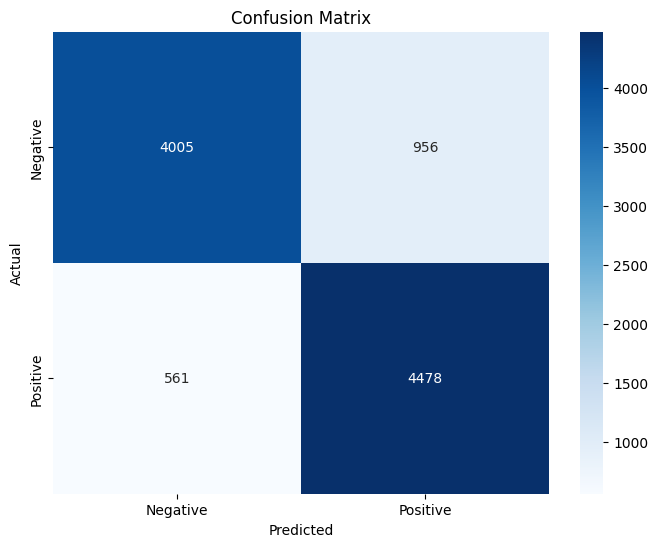

In [23]:
y_pred = model.predict(review_test)

y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(converted_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

#Classification Report
cr = classification_report(converted_test, y_pred_classes, target_names=['Negative', 'Positive'])
print("\nClassification Report:")
print(cr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
import pickle
import os
model.save('imdb_sentiment.h5')

In [ ]:
instance = tokenizer.texts_to_sequences(instance)
flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.9997375]], dtype=float32)

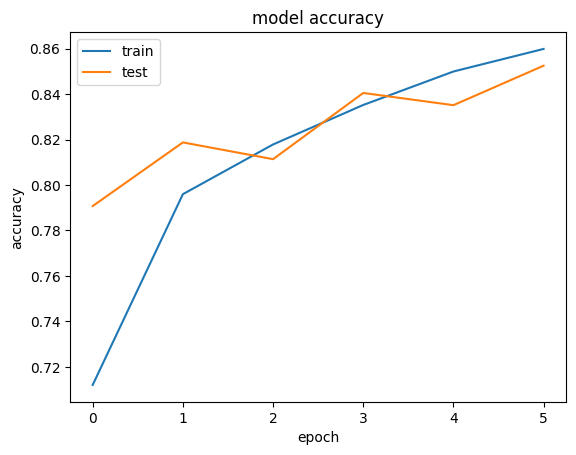

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

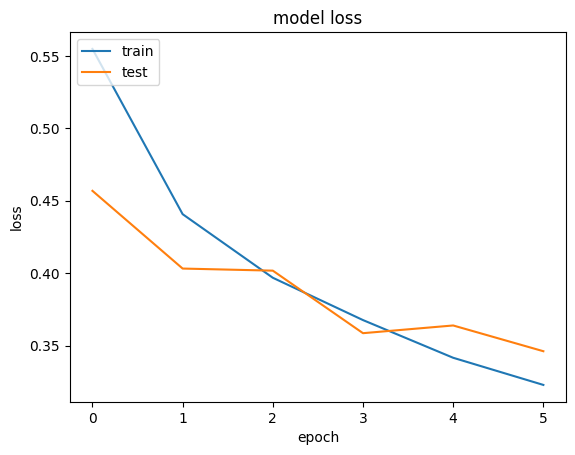

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()